# Test SST Indices Calculations

In [1]:
import sys
sys.path.append(sys.path[0]+'/../..')


import helpers.fileHandler as fh
import utils.sstIndex as sst
import utils._indexDefinitions as _index

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import cftime
import xarray

%matplotlib inline

In [3]:
#get a list of index names to iterate, and then add indian ocean dipole, as a special case
indexNames = list(_index.sstIndex.keys())
indexNames.append('dmi')

In [4]:
def plotter():

    for keys in indexNames:

        try:
            #test if this is an index in cvdp
            cvdp[keys]

        except:
            print (keys, " not defined in Cvdp")        

        else:
            #plot

            #load into memory so it doesn't get loaded twice if we want to use it later
            indexDs[keys].load()

            # set-up plot
            fig = plt.figure(figsize=(15,6))
            ax = fig.add_subplot(1, 1, 1)

            #plot the cvdp
            cvdp[keys].plot(color='green' ,label='from CVDP')

            #plot the calculated one
            indexDs[keys+'NoDetrend'].plot(color='orange',label='calculated')

            #set the horizontal axis to something nice
            plt.xlim(cftime.DatetimeNoLeap(1750,1,1), cftime.DatetimeNoLeap(2050,1,1))

            #add axis names and title
            plt.title(keys)
            plt.ylabel("index", fontsize=16)  
            plt.xlabel("Year", fontsize=16)

            #make it neat
            plt.tick_params(which = 'minor', labelsize=13, length=4)
            plt.tick_params(which = 'major', labelsize=13, length=7)
            ax.grid(which='major', alpha=0.3, linestyle='dashed')

            #show the legend based on the 'labels' set above
            plt.legend()

            #make it so
            plt.show()

            print(keys, " standard deviation of difference: ", (indexDs[keys+'NoDetrend']-cvdp[keys]).std().values)


First load up the cvdp and figure out the details of the index we want to calculate

In [3]:
cvdp = fh.loadModelData('CESM-LME', 'cvdp_data', '005')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/cesm1.lm.cvdp_data/
Files imported: 
 ['/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/cesm1.lm.cvdp_data/b.e11.BLMTRC5CN.f19_g16.005.cvdp_data.850-2005.nc']


Do a sanity check of what the areas are to calculate the indeces

In [4]:
for keys in indexNames:
    try:
        print(keys, ": ", cvdp[keys].comment_cvdp)
    except:
        print (keys, " not defined in Cvdp")



nino34 :  area average domain (-5:5N, 190:240E)
nino4 :  area average domain (-5:5N, 160:210E)
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp
dmi :  area average domain (-10:10N, 50:70E) - (-10:0N, 90:110E)


In [5]:
cvdp.time

<xarray.DataArray 'time' (time: 13872)>
array([cftime.DatetimeNoLeap(850, 1, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(850, 2, 28, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(850, 3, 31, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 11, 30, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00

Next load the model outputs, but drop all the variables we don't care about

In [6]:
ds = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.085001-089912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.090001-099912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.100001-109912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.110001-119912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.120001-129912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.130001-139912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.140001-149912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.150001-159912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.160001-

In [7]:
ds.SST

<xarray.DataArray 'SST' (time: 13872, z_t: 1, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(13872, 1, 384, 320), dtype=float32, chunksize=(1872, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00
Dimensions without coordinates: z_t, nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

# Calculate the indeces from the model outputs

In [ ]:
indexDs = sst.calculateIndex(ds, 850, 2005) #based on 850 to 2005 climatology per CVDP

plotter()

Do a comparison plot. Between calculated indexes and cvdp

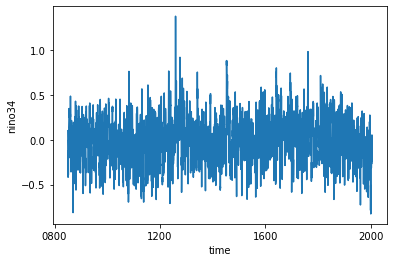

In [9]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34-cvdp.nino34).plot()

In [10]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculated.nc")

/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
indexDs['nino34NoDetrend'].plot(color='orange',label='calculated')
indexDs['nino34'].plot(color='green',label='detrended')

# Same again, but use the climatology from the control run

In [13]:
experimentDs = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.085001-089912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.090001-099912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.100001-109912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.110001-119912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.120001-129912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.130001-139912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.140001-149912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.150001-159912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.160001-

Load the ds to use for climatology

In [14]:
controlDs = fh.loadModelData('CESM-LME', 'SST', '0850cntl.001',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.085001-089912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.090001-099912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.100001-109912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.110001-119912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.120001-129912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.130001-139912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.140001-149912.nc', '/Volumes/Untitled/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.150001-159912.nc', '/Volumes/Untitled/CM

Calculate the indeces from the model outputs

In [15]:
climatDs = sst.calculateClimatology(controlDs, 850, 2005) #based on 850 to 2005 climatology per CVDP


/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/Users/ajs/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

In [20]:
controlDs.TLAT

NameError: name 'controlDs' is not defined

In [ ]:
%time


indexDs = sst.calculateIndex(experimentDs, climatDs) 

plotter

In [ ]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34-cvdp.nino34).plot()

In [ ]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculatedDiffClimatology.nc")

In [ ]:
indexDsStandClimat = xarray.open_dataset('../results/monthlySstIndicesCalculated.nc')

In [ ]:
# set-up plot
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 1, 1)
#plot the calculated one
indexDs['nino34'].plot(color='orange',label='calculated')
indexDsStandClimat['nino34'].plot(color='green',label='calculated')
   #set the horizontal axis to something nice
plt.xlim(cftime.DatetimeNoLeap(1750,1,1), cftime.DatetimeNoLeap(2050,1,1))


# And again with CMIP5

In [20]:
cvdp = fh.loadModelData('CCSM4', 'cvdp_data', 'past1000')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


E:/CMIP5-PMIP3/cmip5.past1000.cvdp_data/
Files imported: 
 ['E:/CMIP5-PMIP3/cmip5.past1000.cvdp_data/CCSM4.cvdp_data.850-1849.nc']


In [21]:
cvdp.climatology

'850-1849 climatology removed prior to all calculations (other than means)'

In [13]:
cvdp

<xarray.Dataset>
Dimensions:                         (TIME: 1000, frequency: 6000, lat: 192, lon: 288, longitude: 129, ncurves: 4, period: 163, time: 12000, time_mon1: 29, time_mon2: 12, time_mon3: 49)
Coordinates:
  * TIME                            (TIME) int32 850 851 852 ... 1847 1848 1849
  * frequency                       (frequency) float32 8.333e-05 ... 0.5
  * lat                             (lat) float64 -90.0 -89.06 ... 89.06 90.0
  * lon                             (lon) float64 0.0 1.25 2.5 ... 357.5 358.8
  * longitude                       (longitude) float64 120.0 121.2 ... 280.0
  * ncurves                         (ncurves) int32 0 1 2 3
  * period                          (period) float32 0.08609 0.09121 ... 997.3
  * time                            (time) object 0850-01-31 00:00:00 ... 184...
  * time_mon1                       (time_mon1) int32 0 1 2 3 4 ... 25 26 27 28
  * time_mon2                       (time_mon2) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * time_mon3                       (time_mon3) int32 0 1 2 3 4 ... 45 46 47 48
Data variables:
    amo_pattern_lowpass_mon         (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_pattern_mon                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_pr_regression_lowpass_mon   (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_pr_regression_mon           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_spectra                     (ncurves, frequency) float32 dask.array<chunksize=(4, 6000), meta=np.ndarray>
    amo_tas_regression_lowpass_mon  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_tas_regression_mon          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    amo_timeseries_lowpass_mon      (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    amo_timeseries_mon              (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    atlantic_meridional_mode        (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    atlantic_nino                   (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    date                            (time) int32 dask.array<chunksize=(12000,), meta=np.ndarray>
    dmi                             (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    ipo_pattern_mon                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ipo_pr_regression_mon           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ipo_spectra                     (ncurves, frequency) float32 dask.array<chunksize=(4, 6000), meta=np.ndarray>
    ipo_tas_regression_mon          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ipo_timeseries_mon              (time) float32 dask.array<chunksize=(12000,), meta=np.ndarray>
    nam_pattern_ann                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pattern_djf                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pattern_jja                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pattern_mam                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pattern_son                 (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pr_regression_ann           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pr_regression_djf           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pr_regression_jja           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pr_regression_mam           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nam_pr_regression_son           (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    na

In [8]:
tsDs = fh.loadModelData('CCSM4', 'ts', 'past1000')
fxDs = fh.loadModelData('CCSM4', 'areacella_fx', 'historical') #There is no file produced for past1000, but the resolution is the same?

E:/CMIP5-PMIP3/past1000/ts/
Files imported: 
 ['E:/CMIP5-PMIP3/past1000/ts/ts_Amon_CCSM4_past1000_r1i1p1_085001-185012.nc']
E:/CMIP5-PMIP3/historical/areacella_fx/
Files imported: 
 ['E:/CMIP5-PMIP3/historical/areacella_fx/areacella_fx_CCSM4_historical_r0i0p0.nc']


In [9]:
ds=xarray.merge([tsDs.ts, fxDs.areacella])

ds=ds.assign_attrs({'project_id':'CMIP5'})


Using model as climatology

In [15]:
indexDs = sst.calculateIndex(ds, 850, 1849) 

Ds looks like CMIP5


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]


In [16]:
indexDs

<xarray.Dataset>
Dimensions:                 (time: 12012)
Coordinates:
  * time                    (time) object 0850-01-16 12:00:00 ... 1850-12-16 ...
    month                   (time) int64 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    nino34NoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4NoDetrend          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    westIONoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIONoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSstNoDetrend  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dmi                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino34                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    westIO                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIO                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSst           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

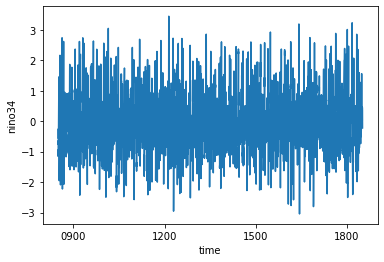

In [17]:
indexDs.nino34.plot()

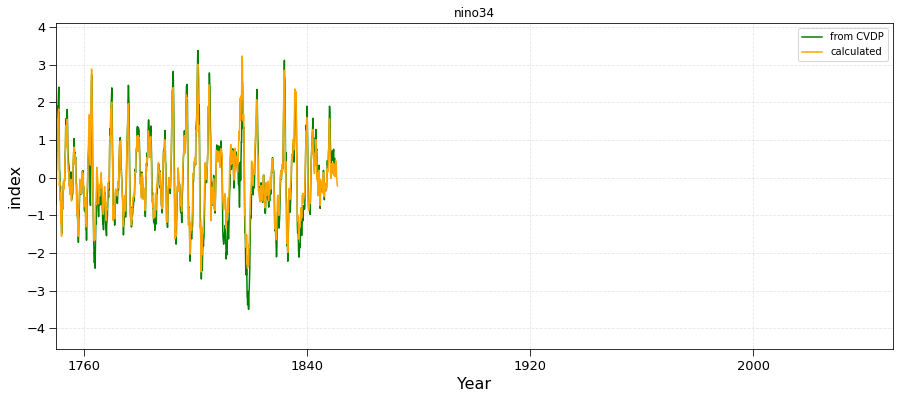

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


nino34  standard deviation of difference:  nan


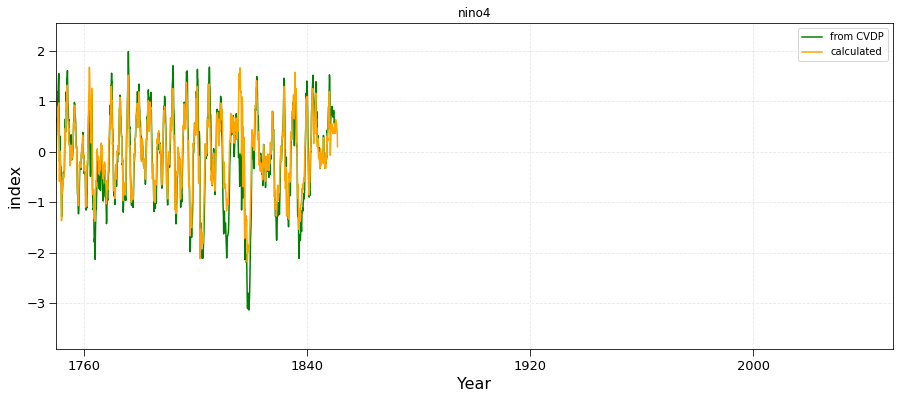

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


nino4  standard deviation of difference:  nan
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp


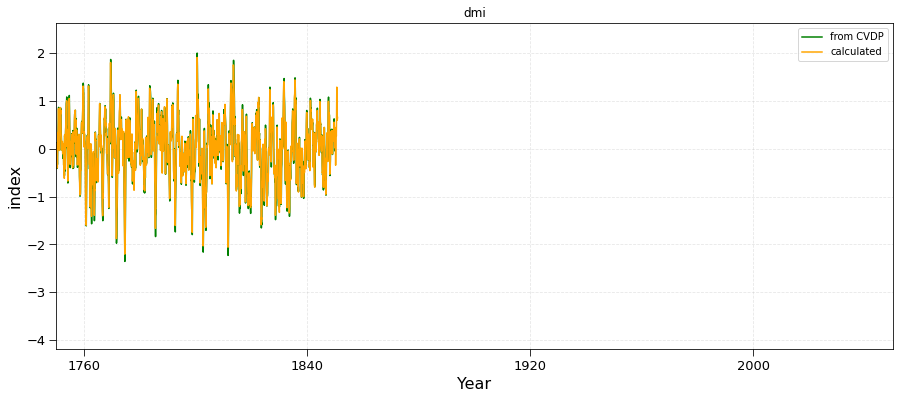

dmi  standard deviation of difference:  nan


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [18]:
plotter()

Using control run as climatology

In [9]:
tsDs = fh.loadModelData('CCSM4', 'ts', 'past1000')
fxDs = fh.loadModelData('CCSM4', 'areacella_fx', 'historical') #There is no file produced for past1000, but the resolution is the same?

E:/CMIP5-PMIP3/past1000/ts/
Files imported: 
 ['E:/CMIP5-PMIP3/past1000/ts/ts_Amon_CCSM4_past1000_r1i1p1_085001-185012.nc']
E:/CMIP5-PMIP3/historical/areacella_fx/
Files imported: 
 ['E:/CMIP5-PMIP3/historical/areacella_fx/areacella_fx_CCSM4_historical_r0i0p0.nc']


In [10]:
ds=xarray.merge([tsDs.ts, fxDs.areacella])
ds=ds.assign_attrs({'project_id':'CMIP5'})


In [11]:
tsControlDs = fh.loadModelData('CCSM4', 'ts', 'piControl')


E:/CMIP5-PMIP3/piControl/ts/
Files imported: 
 ['E:/CMIP5-PMIP3/piControl/ts/ts_Amon_CCSM4_piControl_r1i1p1_025001-050012.nc', 'E:/CMIP5-PMIP3/piControl/ts/ts_Amon_CCSM4_piControl_r1i1p1_050101-079912.nc', 'E:/CMIP5-PMIP3/piControl/ts/ts_Amon_CCSM4_piControl_r1i1p1_080001-130012.nc']


In [12]:
controlDs=xarray.merge([tsControlDs.ts, fxDs.areacella])
controlDs=controlDs.assign_attrs({'project_id':'CMIP5'})


In [15]:
controlDs

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, time: 12612)
Coordinates:
  * time       (time) object 0250-01-16 12:00:00 ... 1300-12-16 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(3012, 192, 288), meta=np.ndarray>
    areacella  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes:
    project_id:  CMIP5

In [16]:
climatDs=sst.calculateClimatology(controlDs, 250, 1300)

Ds looks like CMIP5


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Using model as climatology

In [17]:
indexDs = sst.calculateIndex(ds, climatDs) 

Ds looks like CMIP5


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 1001 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]


In [18]:
indexDs

<xarray.Dataset>
Dimensions:                 (time: 12012)
Coordinates:
  * time                    (time) object 0850-01-16 12:00:00 ... 1850-12-16 ...
    month                   (time) int64 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    nino34NoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4NoDetrend          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    westIONoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIONoDetrend         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSstNoDetrend  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dmi                     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino34                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    nino4                   (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    westIO                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    eastIO                  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    backgroundSst           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

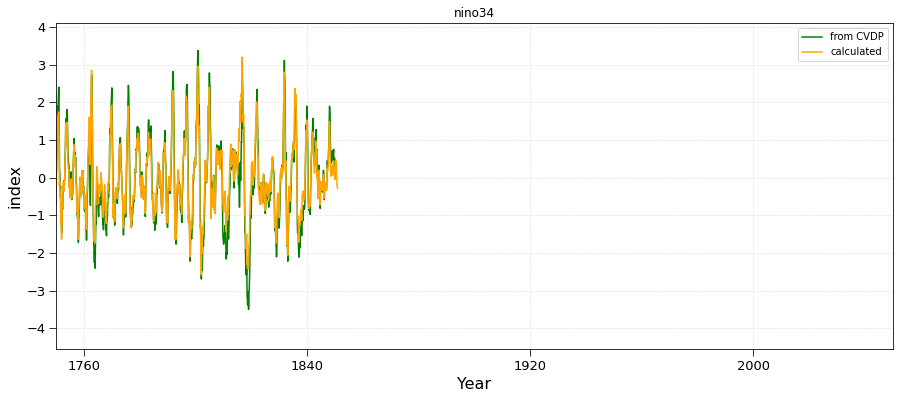

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


nino34  standard deviation of difference:  nan


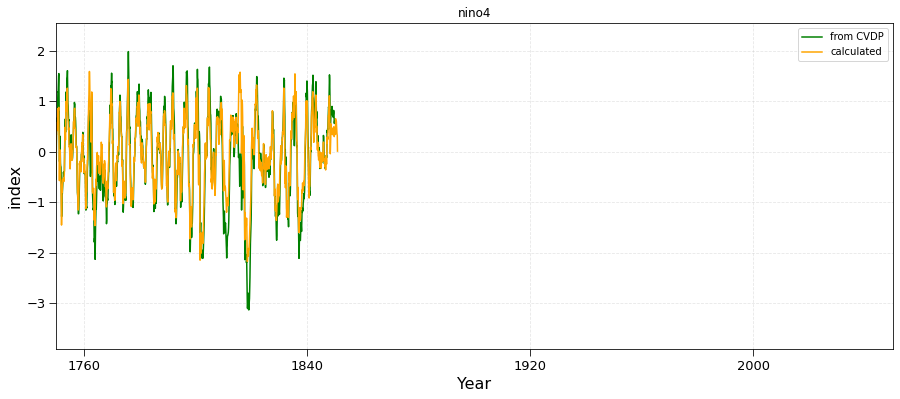

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


nino4  standard deviation of difference:  nan
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp


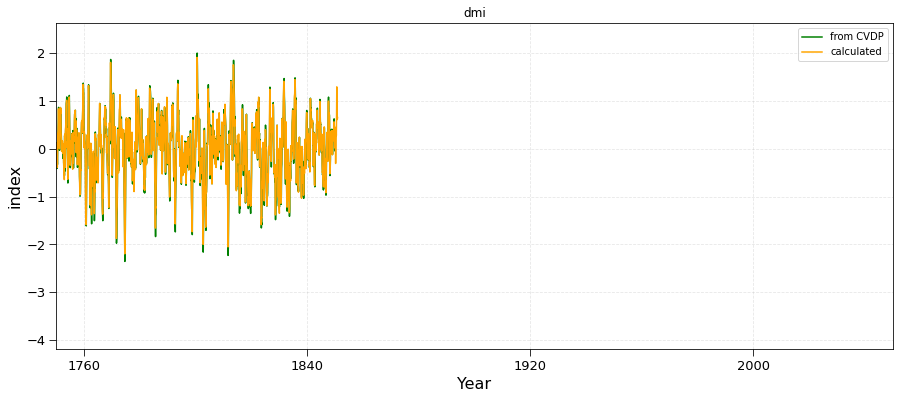

dmi  standard deviation of difference:  nan


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [22]:
plotter()